In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.chdir('../');

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import V1_circuit
from dsn.util.dsn_util import setup_IO
from dsn.util.plot_util import assess_constraints, plot_opt

# normalizing flow layer architecture
flow_type = 'PlanarFlowLayer'
# number of layers
nlayers = 10
flow_dict = {'latent_dynamics':None, \
             'TIF_flow_type':flow_type, \
             'repeats':nlayers, \
             'scale_layer':True}
# multivariate normal initialization variance
sigma_init = 1.0
random_seed = 1

In [3]:
# create an instance of the V1_circuit system class
fixed_params = {'W_EE':1.0, \
                'W_PE':1.0, \
                'W_SE':1.0, \
                'W_VE':1.0, \
                'h_FFE':0.0, \
                'h_FFP':0.0, \
                'h_LATE':0.0, \
                'h_LATP':0.0, \
                'h_LATS':0.0, \
                'h_LATV':0.0, \
                'tau':1.0, \
                'n':2.0, \
                's_0':30};


c_vals=np.array([0.0])
s_vals=np.array([1.0])
r_vals=np.array([0.0, 1.0])
d_mean = np.zeros((4,))
d_vars = np.ones((4,))
behavior = {'type':'difference', \
            'c_vals':c_vals, \
            's_vals':s_vals, \
            'r_vals':r_vals, \
            'd_mean':d_mean, \
            'd_var':d_vars}

# set model options
model_opts = {'g_FF':'c', 'g_LAT':'linear', 'g_RUN':'r'}

T = 20
dt = 0.25

T_gt = 1000
dt_gt = 0.01


In [40]:
r_t_list = [];
r_t_gt_list = [];

num_r0s = 50;
for i in range(num_r0s):
    r0_samp = np.abs(np.random.normal(0,1,(4,)));
    init_conds=np.expand_dims(r0_samp, 1)
    system = V1_circuit(fixed_params, behavior, model_opts, T, dt, init_conds)
    system_gt = V1_circuit(fixed_params, behavior, model_opts, T_gt, dt_gt, init_conds)

    z = tf.placeholder(dtype=tf.float64, shape=(1, None, system.D, 1));
    r_t = system.simulate(z)
    r_t_gt = system_gt.simulate(z)

    _z = np.expand_dims(np.expand_dims(np.expand_dims(np.arange(0, 1.01, .2), 0), 2), 3)
    num_inputs = _z.shape[1]
    _z = np.tile(_z, [1, 1, 8, 1]);

    with tf.Session() as sess:
        _r_t = sess.run(r_t, {z:_z})
        _r_t_gt = sess.run(r_t_gt, {z:_z})
        
    r_t_list.append(_r_t)
    r_t_gt_list.append(_r_t_gt)

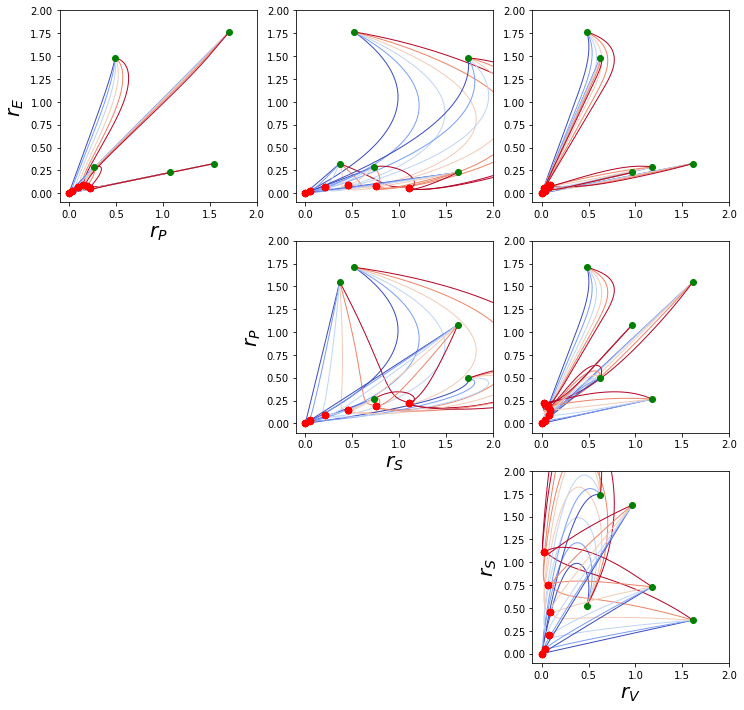

In [42]:
num_ntypes = 4
c = 0;
axlim = 2.0;
cm = plt.cm.get_cmap('coolwarm');
fig, axs = plt.subplots(num_ntypes-1, num_ntypes-1, figsize=(12,12))
labels = [r'$r_E$', r'$r_P$', r'$r_S$', r'$r_V$']
fontsize = 20
for ii in range(5):
    _r_t_gt = r_t_gt_list[ii]
    for i in range(num_ntypes-1):
        for j in range(1,num_ntypes):
            ax = axs[i][j-1]
            if (j > i):
                for k in range(num_inputs):
                    ax.plot(_r_t_gt[:,c,k,j,0], _r_t_gt[:,c,k,i,0], c=cm(_z[0,k,0,0]), lw=1, zorder=1)
                    if (k==0):
                        ax.scatter(_r_t_gt[0,c,0,j,0], _r_t_gt[0,c,0,i,0], c='g', zorder=2)
                    ax.scatter(_r_t_gt[-1,c,k,j,0], _r_t_gt[-1,c,k,i,0], s=40, c='r', zorder=2)
                ax.set_xlim([-.1, axlim])
                ax.set_ylim([-.1, axlim])
            else:
                ax.axis('off')
                
            if (j==i+1):
                ax.set_xlabel(labels[j], fontsize=fontsize)
                ax.set_ylabel(labels[i], fontsize=fontsize)
            
            
plt.show()
        

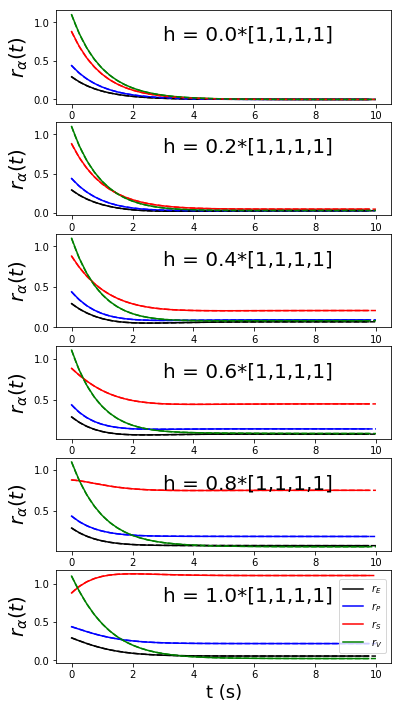

In [69]:
T = 40
dt = 0.25

T_gt = 1000
dt_gt = 0.01

r0_samp = np.abs(np.random.normal(0,1,(4,)))
init_conds=np.expand_dims(r0_samp, 1)
system = V1_circuit(fixed_params, behavior, model_opts, T, dt, init_conds)
system_gt = V1_circuit(fixed_params, behavior, model_opts, T_gt, dt_gt, init_conds)

z = tf.placeholder(dtype=tf.float64, shape=(1, None, system.D, 1));
r_t = system.simulate(z)
r_t_gt = system_gt.simulate(z)

_z = np.expand_dims(np.expand_dims(np.expand_dims(np.arange(0, 1.01, .2), 0), 2), 3)
num_inputs = _z.shape[1]
_z = np.tile(_z, [1, 1, 8, 1]);

with tf.Session() as sess:
    _r_t = sess.run(r_t, {z:_z})
    _r_t_gt = sess.run(r_t_gt, {z:_z})
    
t = np.arange(0, dt*T, dt)
t_gt = np.arange(0, dt_gt*T_gt, dt_gt)

plt.figure(figsize=(6,12))
for k in range(num_inputs):
    plt.subplot(num_inputs,1, k+1);
    plt.plot(t, _r_t[:,c,k,0,0], c='k')
    plt.plot(t, _r_t[:,c,k,1,0], c='b')
    plt.plot(t, _r_t[:,c,k,2,0], c='r')
    plt.plot(t, _r_t[:,c,k,3,0], c='g')

    plt.plot(t_gt, _r_t_gt[:,c,k,0,0], 'k--')
    plt.plot(t_gt, _r_t_gt[:,c,k,1,0], 'b--')
    plt.plot(t_gt, _r_t_gt[:,c,k,2,0], 'r--')
    plt.plot(t_gt, _r_t_gt[:,c,k,3,0], 'g--')

    
    plt.ylabel(r'$r_\alpha(t)$', fontsize=fontsize)
    plt.xlabel('t (s)', fontsize=fontsize-2)
    plt.text(3, .7*np.max(_r_t_gt[:,c,k,3,0]), 'h = %.1f*[1,1,1,1]' % _z[0,k,0,0], fontsize=fontsize)

plt.legend(labels)
plt.show()

In [70]:
T_x = system.compute_suff_stats(z)
print(T_x.shape)

(1, ?, 8)


In [93]:
bound = 1.0;
start = 0.0;
stop = bound;
res = 0.5;
eps = .001*res;
vals = np.arange(start, stop+eps, res);
num_pts = vals.shape[0];

total_pts = num_pts**8;
params = np.zeros((total_pts,8));
ind = 0;
for i in range(num_pts):
    b_E = vals[i];
    for j in range(num_pts):
        b_P = vals[j];
        for k in range(num_pts):
            b_S = vals[k];
            for l in range(num_pts):
                b_V = vals[l];
                for ii in range(num_pts):
                    h_RUNE = vals[ii];
                    for jj in range(num_pts):
                        h_RUNP = vals[jj];
                        for kk in range(num_pts):
                            h_RUNS = vals[kk];
                            for ll in range(num_pts):
                                h_RUNV = vals[ll];
                                params[ind,:] = np.array([b_E, b_P, b_S, b_V, \
                                                          h_RUNE, h_RUNP, h_RUNS, h_RUNV]);
                                ind += 1;
                                

In [94]:
_z = np.expand_dims(np.expand_dims(params, 0), 3)
with tf.Session() as sess:
    _T_x = sess.run(T_x, {z:_z})

0.02167863556466059 0
0.12856277924456627 0
1.0691767850349143 0
0.2524681803668821 0
0.17256964530287666 0
0.09363059796628005 0
2.1755949346695136 0
2.0235043044975907 0


<Figure size 864x864 with 0 Axes>

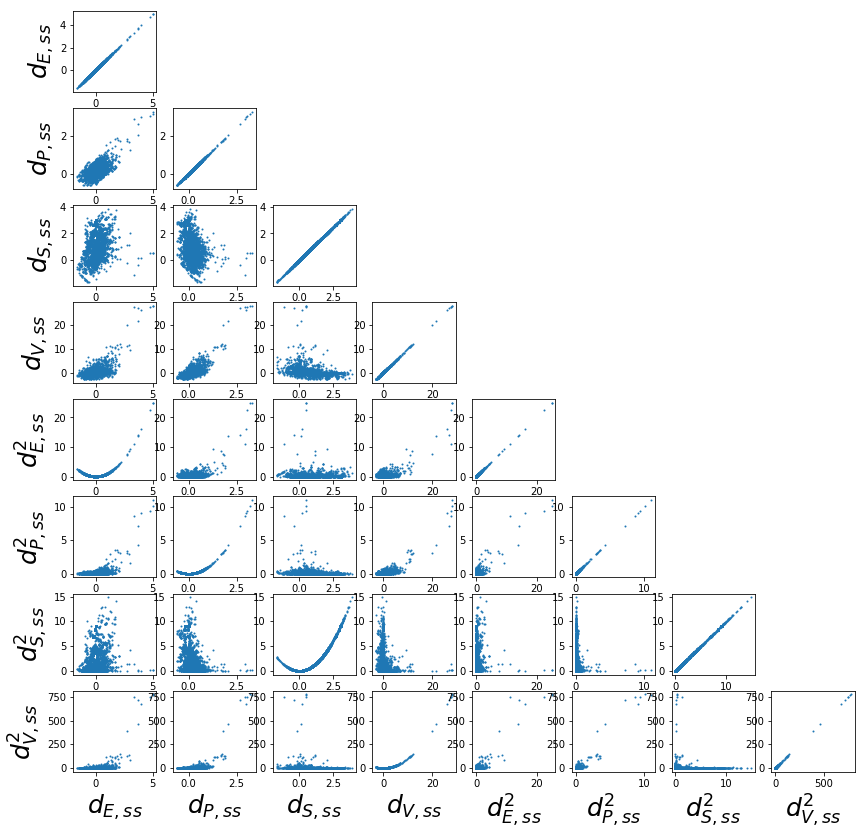

In [95]:
figsize = (12,12);
fontsize = 12;
plt.figure(figsize=figsize);

bound = 2;
fontsize = 25;
figsize = (14, 14);
plt.figure(figsize=figsize);
for i in range(system.num_suff_stats):
    plt.subplot(1, system.num_suff_stats, i+1);
    for j in range(system.num_suff_stats):
        ind = system.num_suff_stats*i + j + 1;
        plt.subplot(system.num_suff_stats, system.num_suff_stats, ind);
        plt.scatter(_T_x[0,:,j], _T_x[0, :, i], s=1);
        if (i==(system.D-1)):
            plt.xlabel(system.T_x_labels[j], fontsize=fontsize);
        if (j==0):
            plt.ylabel(system.T_x_labels[i], fontsize=fontsize);
        #plt.xlim([-bound, bound]);
        #plt.ylim([-bound, bound]);
    print(np.mean(_T_x[0,:,i]),0);

plt.show();



In [6]:
init_conds = np.expand_dims(np.array([1.0, 1.1, 1.2, 1.3]), 1)

system = V1_circuit(fixed_params, behavior, model_opts, T, dt, init_conds)

k_max = 25
batch_size = 1000;
c_init_order = -5
lr_order = -3

c_vals=np.array([0.0])
s_vals=np.array([1.0])
r_vals=np.array([0.0, 1.0])
d_mean = np.array([1.0, 0.25, 1.0, 0.0]);
d_vars = np.array([0.01, 0.01, 0.01, 0.01]);
behavior = {'type':'difference', \
            'c_vals':c_vals, \
            's_vals':s_vals, \
            'r_vals':r_vals, \
            'd_mean':d_mean, \
            'd_var':d_vars}

train_dsn(system, batch_size, flow_dict, \
          k_max=k_max, sigma_init=sigma_init, c_init_order=c_init_order, lr_order=lr_order,\
          random_seed=random_seed, min_iters=5000, max_iters=10000, \
          check_rate=100, dir_str='test')

results/inits/D=8_M_10P_sigma=1.00_rs=1/
0 <tf_util.flows.ElemMultLayer object at 0x1a31cfc470>
1 <tf_util.flows.PlanarFlowLayer object at 0x1a31cfc4a8>
2 <tf_util.flows.PlanarFlowLayer object at 0x1a31cfc320>
3 <tf_util.flows.PlanarFlowLayer object at 0x1a31cfc5c0>
4 <tf_util.flows.PlanarFlowLayer object at 0x1a31ccdf60>
5 <tf_util.flows.PlanarFlowLayer object at 0x1a31ccd7b8>
6 <tf_util.flows.PlanarFlowLayer object at 0x1a31ccd9e8>
7 <tf_util.flows.PlanarFlowLayer object at 0x1a31ccd860>
8 <tf_util.flows.PlanarFlowLayer object at 0x1a31ccdfd0>
9 <tf_util.flows.PlanarFlowLayer object at 0x1a31ccdeb8>
10 <tf_util.flows.PlanarFlowLayer object at 0x1a31ccd7f0>
0 ScalarFlow_Layer_1
1 PlanarFlow_Layer2
2 PlanarFlow_Layer3
3 PlanarFlow_Layer4
4 PlanarFlow_Layer5
5 PlanarFlow_Layer6
6 PlanarFlow_Layer7
7 PlanarFlow_Layer8
8 PlanarFlow_Layer9
9 PlanarFlow_Layer10
10 PlanarFlow_Layer11
11 SoftPlusLayer
training DSN for V1_circuit
AL iteration 1
resetting optimizer
Aug Lag it 0
saving model at 

KeyboardInterrupt: 